##Import Packages

In [ ]:
#install related packages
!pip install transformers
!pip install umap-learn

In [ ]:
#import initial packages
import re
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
c_map = plt.cm.get_cmap('Paired')
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud
import os
import string
from operator import index
import pickle
import gdown

#nltk setup
from nltk.corpus import wordnet
from nltk.corpus import semcor
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import semcor
from nltk.corpus import wordnet as wn 
from nltk.corpus.reader.wordnet import Lemma
from nltk.corpus.reader.wordnet import Synset
from re import sub

#embedding packages / BERT
import torch
import transformers
from transformers import BertTokenizer, BertModel
#ElMo
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# clustring
from sklearn.cluster import KMeans, DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import adjusted_rand_score, completeness_score, \
homogeneity_score, v_measure_score, accuracy_score, silhouette_score, make_scorer
from sklearn.metrics import normalized_mutual_info_score, fowlkes_mallows_score, jaccard_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats
import itertools
from sklearn.model_selection import GridSearchCV

#imablanc handling
from imblearn.over_sampling import SMOTE

#dimensionality reduction
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch # importing scipy.cluster.hierarchy for dendrogram

#system setup
from google.colab import drive
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

#access to my drive
drive.mount('/content/drive')

<ipython-input-2-8d4c5d83bcbc>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('Paired')


Mounted at /content/drive


### BERT setup

In [ ]:
n_emb_base = 768
tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Load pre-trained model (weights)
model_base = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Put the model in "evaluation" mode, meaning feed-forward operation.
model_base.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
def getEmbedingBERT(text , desired_word_em, model, tokenizer):
  # Run the text through BERT, and collect all of the hidden states produced
  # from all 12 layers. 
  
  # Convert inputs to PyTorch tensors
  # Mark each of the 22 tokens as belonging to sentence "1".
  marked_text = "[CLS] " + text + " [SEP]"

  # Split the sentence into tokens.
  tokenized_text = tokenizer.tokenize(marked_text)

  # Map the token strings to their vocabulary indeces.
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

  try:
    idx = np.where(np.array(tokenized_text) == desired_word_em)[0][0]
  except:
    print('except !!!!!!!!!!!!!!!!!!!', text)
    pass

  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  
  tokenized_text = tokenizer.tokenize(marked_text)
  with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings[8, idx, :]
    # bert_semcor_index.append(idx)
  return token_embeddings

In [ ]:
# #to see if punctuations can influence embedding as hotel reviews doesn't have punc
# def remove_puncs(text):
#   text = text.translate(str.maketrans('', '', string.punctuation))
#   text = text.replace('  ',' ')
#   return text

##myword

In [ ]:
myword = 'state' #challenge for the begging and end of a sentence. Think later/

## SemCor Corpus



In [ ]:
nltk.download('semcor')
semcor_words = semcor.words()
# len(semcor_words) #820411
semcor_chunks = semcor.chunks()
# len(semcor_chunks) #778587
semcor_sents = semcor.sents()
# len(semcor_sent) #37176

tag – ‘pos’ (part of speech), ‘sem’ (semantic), or ‘both’ to indicate the kind of tags to include. Semantic tags consist of WordNet lemma IDs, plus an ‘NE’ node if the chunk is a named entity without a specific entry in WordNet. (Named entities of type ‘other’ have no lemma. Other chunks not in WordNet have no semantic tag. Punctuation tokens have None for their part of speech tag.)

an example for 'both':
Tree('however.r.01', [Tree('RB', ['However'])]

for 'sem': Tree('however.r.01', ['However'])

for 'pos': Tree('RB', ['However'])

In [ ]:
len_semcor_sentences = 37176 #len(semcor.sents())
#extracting sentences including my_word
if not os.path.exists('/content/drive/MyDrive/Thesis/SemCor_'+myword+'_df'):
  #access to google drive

  url_myword_df = '/content/drive/MyDrive/Thesis/' + 'SemCor_' + str(myword) + '_df'
  myword_sent = [] 
  myword_index = []
  [(myword_sent.append((s)), myword_index.append(i)) 
  for s, i in tqdm(zip(semcor.tagged_sents(tag='both')[:len_semcor_sentences],
                       range(len_semcor_sentences))) if '\''+myword+'\'' in str(s).lower()]
  
  #build a dictionary of myword senatnces and indecies
  myword_semcor_dict = {'semcor_idx_'+str(myword): myword_index,
                        'semcor_sent_'+str(myword): myword_sent}
  #construct dataframe of myword sents and idx
  myword_semcor_df = pd.DataFrame(myword_semcor_dict)
  #save the df
  open_file = open(url_myword_df, "wb")
  pickle.dump(myword_semcor_df, open_file)
  open_file.close()
else:
  # open files of myword
  open_file = open('/content/drive/MyDrive/Thesis/SemCor_'+myword+'_df', "rb")
  myword_semcor_df = pickle.load(open_file)
  open_file.close()
myword_index = myword_semcor_df['semcor_idx_'+str(myword)].values
myword_sent = myword_semcor_df['semcor_sent_'+str(myword)].values

# myword_semcor_df['myword_wsns'] = None 
# myword_semcor_df['myword_POS'] = None

print('#SemCor sentences contain word', myword, ': ', len(myword_sent))
print(semcor_sents[myword_index[0]])

#SemCor sentences contain word state :  567
['The', 'grand', 'jury', 'took', 'a', 'swipe', 'at', 'the', 'State', 'Welfare', 'Department', "'s", 'handling', 'of', 'federal', 'funds', 'granted', 'for', 'child', 'welfare', 'services', 'in', 'foster', 'homes', '.']


In [ ]:
semcor.tagged_chunks(tag=("both"))
print(semcor_sents[30285])

In [ ]:
#finding the sense and POS tag (label) of myword in the sentences
myword_semcor_POS = []
myword_semcor_wsns = []
outdate_indices = []
POS_wsns_idx = []

for i in range(len(myword_sent)):
  if len(re.findall(myword, str(myword_sent[i]).lower().replace("'",""))) == 2:
    #fiding the start index
    idx_start = str(myword_sent[i]).lower().replace("'","").find(myword)
    #finding sense of a WORD (WSNS)
    idx_dot = str(myword_sent[i]).replace("'","").find('.', idx_start)
    idx_comma = str(myword_sent[i]).replace("'","").find(',', idx_dot)
    myword_semcor_wsns.append(str(myword_sent[i]).replace("'","")[idx_dot+1: idx_comma])
    #go back enough to find the second myword
    idx_start = str(myword_sent[i]).lower().replace("'","").find(myword, idx_comma) - 9
    #go forward to find the part of speech start index
    idx1 = str(myword_sent[i]).replace("'","").find('(',idx_start)
    #part of speech end index
    idx2 = str(myword_sent[i]).replace("'","").find(',',idx1)
    #generate the label list
    myword_semcor_POS.append(str(myword_sent[i]).replace("'","")[idx1+1: idx2])

  elif len(re.findall(myword, str(myword_sent[i]).lower().replace("'",""))) == 1:
    myword_semcor_wsns.append('')
    idx_start = str(myword_sent[i]).lower().replace("'","").find(myword) - 9
    idx1 = str(myword_sent[i]).replace("'","").find('(',idx_start) + 1
    idx2 = str(myword_sent[i]).replace("'","").find(',',idx1)
    myword_semcor_POS.append(str(myword_sent[i]).replace("'","")[idx1: idx2])
  
  else:
    myword_semcor_wsns.append('')
    myword_semcor_POS.append('')
  #create a list of indices with unfamilar tags
  if len(myword_semcor_POS[-1]) > 3 or (')' in myword_semcor_wsns[-1]) \
  or (';' in myword_semcor_wsns[-1]) or len(myword_semcor_wsns[-1]) == 0:
  # or ('v' in myword_semcor_wsns[-1]) or ('n' in myword_semcor_wsns[-1])\
  # or ('r' in myword_semcor_wsns[-1]) or ('N' in myword_semcor_POS[-1])
  
    outdate_indices.append(i)
    myword_semcor_POS.pop()
    myword_semcor_wsns.pop()
print(len(outdate_indices))

'v.01'

In [ ]:
myword_semcor_label = set(myword_semcor_wsns)
print(set(myword_semcor_wsns))
print(len(set(myword_semcor_wsns)))
print(set(myword_semcor_POS))
print(len(set(myword_semcor_POS)))

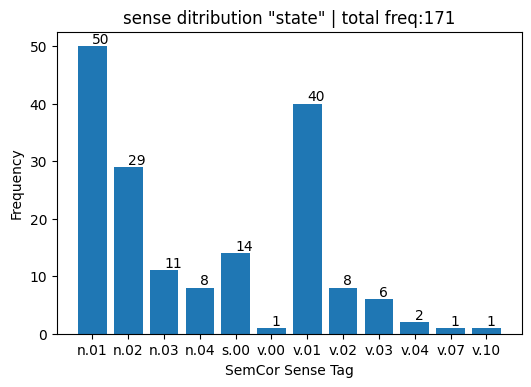

In [ ]:
plt.figure(figsize=(6,4), dpi=100)
labels, counts = np.unique(myword_semcor_wsns, return_counts=True)
myword_hist = plt.bar(labels, counts, align='center', color='C0')
n_neighbour_smote = np.min(counts).astype(int) - 1
for i in range(len(counts)):
  plt.text(labels[i], counts[i]+0.5, counts[i])
# plt.title(myword+" sense distribution")
plt.xlabel('SemCor Sense Tag') 
plt.ylabel('Frequency')
plt.title('sense ditribution "'+ myword + '" | total freq:' + str(sum(counts)))
plt.show()

In [ ]:
#update myword index and sentence
myword_index_new = []
myword_sent_new = []
for i in range(len(myword_index)):
  if i in outdate_indices:
    pass
  else:
    myword_index_new.append(myword_index[i])
    myword_sent_new.append(myword_sent[i])

myword_semcor_def = []
for i in range(len(myword_semcor_wsns)):
  myword_semcor_def.append(str(myword_semcor_wsns[i]))
len(myword_index_new)

In [ ]:
myword_sentence_new = []
for i in myword_index_new:
  myword_sentence_new.append(' '.join(semcor_sents[i]))

#save a file include myword details
myword_semcor_detail_dict = {'semcor_idx_'+str(myword): myword_index_new,
                             'semcor_sense_'+str(myword): myword_semcor_def,
                             'semcor_sent_'+str(myword): myword_sentence_new}
myword_semcor_detail_df = pd.DataFrame(myword_semcor_detail_dict)
# myword_semcor_detail_df.to_excel('SemCor_' + str(myword) + '_detail.xlsx')


#finding the index of my_word in each sentence to have (greater, greatest, ...)
list_of_myword = []
for i in myword_index_new:
  idx = ' '.join(semcor_sents[i]).find(myword)
  idx_end = ' '.join(semcor_sents[i]).find(' ', idx)
  if idx_end == -1:
    continue
  list_of_myword.append(' '.join(semcor_sents[i])[idx:idx_end])

list_of_myword = set(list_of_myword)

list_of_myword = myword # for test
print(list_of_myword)

state


## BERT Embedding extraction

In [ ]:
#Semcor BERT embedding
semcor_BERT_base_embs = np.zeros((len(myword_index_new) , n_emb_base))
#extract bert_base embedding
for i in tqdm(range(len(myword_index_new))):
  text = ' '.join(semcor_sents[myword_index_new[i]])
  # text = remove_puncs(text)
  # text = text.lower()
  try:
    em = getEmbedingBERT(text, myword, model_base, tokenizer_base)
    semcor_BERT_base_embs[i] = em
  except:
    print('except ************')
    pass


idx_hold_base = np.where(np.sum(semcor_BERT_base_embs, axis=1)!=0)[0]
semcor_BERT_base_embs = semcor_BERT_base_embs[idx_hold_base]
myword_semcor_base_labels = np.array(myword_semcor_def)[idx_hold_base.astype(int)]

  0%|          | 0/171 [00:00<?, ?it/s]

In [ ]:
print(len(myword_semcor_base_labels))

171


In [ ]:
#convert categorical (sense label) to numerical
set_labels, numerical_sense_labels = np.unique(myword_semcor_base_labels, return_inverse=True)

## Cluster reviews

### Dendrogram


In [ ]:
#make the sentences includes desire_word shorter
short_sent = []
cnt = 0

for text in list(myword_semcor_detail_df[:25]['semcor_sent_'+myword]):
  start = text.find(myword)
  if start != -1:
    text = text[:start]+' "'+text[start:start+len(myword)]+'" '+text[start+len(myword)+6:]
    start = max(0, start-60)
    end = min(len(text), start+len(myword)+60+60)
    short_sent.append(text[start:end]+": '" + myword_semcor_detail_df[cnt:cnt+1]['semcor_sense_'+myword][cnt]+"'")
    cnt += 1

In [ ]:
# plt.figure(figsize=(7,5), dpi=250)
# dendrogram = sch.dendrogram(sch.linkage(semcor_BERT_base_embs[:25],
#                                         method='ward'), labels=short_sent,
#                             leaf_rotation=0.,
#                             leaf_font_size=10,
#                             orientation='right') # finding the optimal number of clusters using dendrogram

# plt.title('Dendrogram of "'+myword+'"') # title of the dendrogram
# plt.xlabel('Euclidean distances') # label of the x-axis
# plt.ylabel('Tokens') # label of the y-axis
# plt.show() # show the dendrogram

## imbalnace handling

In [ ]:
# smt = SMOTE(k_neighbors=n_neighbour_smote)
# semcor_BERT_base_embs_bal, numerical_sense_labels_bal = \
#  smt.fit_resample(semcor_BERT_base_embs, numerical_sense_labels)

# semcor_GPT_embs_bal, numerical_sense_labels_gpt_bal = \
#  smt.fit_resample(semcor_GPT_embs, numerical_sense_labels)

# plt.figure(figsize=(6,4), dpi=200)
# labels, counts = np.unique(numerical_sense_labels_bal, return_counts=True)
# myword_hist = plt.bar(labels, counts, align='center', color='C0')
# n_neighbour_smote = np.min(counts).astype(int) - 1
# for i in range(len(counts)):
#   plt.text(labels[i], counts[i]+0.5, counts[i])
# plt.xlabel('SemCor Sense Tag') 
# plt.ylabel('Frequency')
# plt.show()

## Clustering Systems

### k-means

In [ ]:
#objects
if len(set(myword_semcor_wsns)) > 5:
  n_clst = 5
else:
  n_clst = len(set(myword_semcor_wsns))
print('Nr. k-means clusters: ', n_clst)

#kmeans + BERT embedding
bert_base_kmeans = KMeans(n_clusters=n_clst, max_iter=1000, tol=0.001,
                          random_state=None, n_init=10, init="random")
bert_base_kmeans.fit(semcor_BERT_base_embs)
kmeans_labels_semcor_bert = bert_base_kmeans.predict(semcor_BERT_base_embs)

Nr. k-means clusters:  5


### Hierarchial

In [ ]:
bert_base_agg_hc = AgglomerativeClustering(n_clusters=n_clst, affinity = 'euclidean', linkage='ward')

# model fitting on the dataset
bert_base_agg_hc.fit_predict(semcor_BERT_base_embs)

#labels
agg_hc_base_labels = bert_base_agg_hc.labels_

### DBSCAN

In [ ]:
# #dbscan + BERT embedding
# dbscan = DBSCAN(metric='euclidean')
# # Define the parameter grid for DBSCAN
# param_grid = {'eps': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 3, 4, 10, 20],
#               'min_samples': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]}

# # Define the grid search
# # grid_search_dbscan = GridSearchCV(dbscan, param_grid, verbose=1,
# #                                   cv=5, scoring=silhouette_score)

# #train
# labels = grid_search_dbscan.fit_predict(semcor_BERT_base_embs)
# print(grid_search_dbscan.best_params_)

# # Generate labels for data with model with raw data, compute score
# score = silhouette_score(semcor_BERT_base_embs, labels)
# # Print the best parameters and the corresponding silhouette score
# print("Best eps: ", grid_search_dbscan.best_params_['eps'])
# print("Best min_samples: ", grid_search_dbscan.best_params_['min_samples'])
# print("Best adjusted_rand_score score: ", score)

# #dbscan + BERT embedding
# bert_base_dbscan = DBSCAN(metric='euclidean', eps=0.5, min_samples=18)
# dbscan_labels_semcor_bert = bert_base_dbscan.fit_predict(semcor_BERT_base_embs)

## Dimensionality Reduction Process

### Principle Component Analysis (PCA)


In [ ]:
mms = MinMaxScaler()

Text(0.5, 1.0, 'PCA | State')

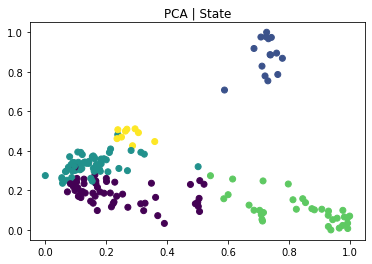

In [ ]:
#PCA setup
pca_base_5C = PCA(n_components=5, random_state=42)
# base fit and transform
pca_base_5C.fit(semcor_BERT_base_embs)
pca_bert_base_5C = pca_base_5C.transform(semcor_BERT_base_embs)

pca_bert_base_5C = mms.fit_transform(pca_bert_base_5C)
plt.scatter(pca_bert_base_5C[:,0], pca_bert_base_5C[:,1], c=kmeans_labels_semcor_bert)
plt.title("PCA | "+myword.capitalize())

### Uniform Manifold Approximation and Projection (UMAP)

Text(0.5, 1.0, 'UMAP | State')

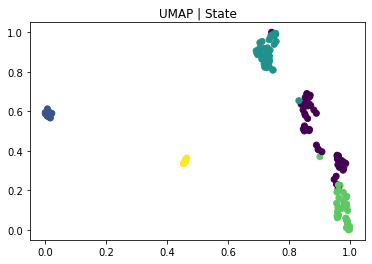

In [ ]:
#umap object
umap_base_5C = UMAP(n_neighbors=10, n_components=5, random_state=20)
umap_base_5C.fit(semcor_BERT_base_embs)
umap_bert_base_5C = umap_base_5C.transform(semcor_BERT_base_embs)

umap_bert_base_5C = mms.fit_transform(umap_bert_base_5C)
plt.scatter(umap_bert_base_5C[:,0], umap_bert_base_5C[:,1], c=kmeans_labels_semcor_bert)
plt.title("UMAP | "+myword.capitalize())

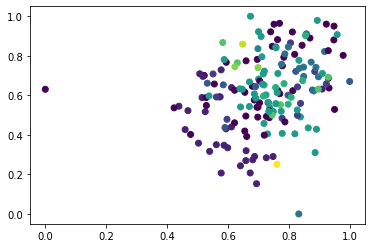

In [ ]:
#tsne object
tsne_base_5C = TSNE(n_components=5, learning_rate='auto',
                    init='random', perplexity=15, method='exact', random_state=42)
tsne_bert_base_5C = tsne_base_5C.fit_transform(semcor_BERT_base_embs)

tsne_bert_base_5C = mms.fit_transform(tsne_bert_base_5C)
plt.scatter(tsne_bert_base_5C[:,0], tsne_bert_base_5C[:,1], c=numerical_sense_labels)
# plt.title("tSEN | "+myword.capitalize())

### Keamns after PCA - UMAP 

In [ ]:
#3 components
bert_base_kmeans_PCA_5C = KMeans(n_clusters=n_clst, max_iter=1000, tol=0.001,
                                 random_state=None, n_init=10, init="random")
#train
bert_base_kmeans_PCA_5C.fit(pca_bert_base_5C)
kmeans_labels_semcor_PCA_5C = bert_base_kmeans_PCA_5C.predict(pca_bert_base_5C)

In [ ]:
#3 components
bert_base_kmeans_UMAP_5C = KMeans(n_clusters=n_clst, max_iter=1000, tol=0.001,
                                 random_state=None, n_init=10, init="random")
#train
bert_base_kmeans_UMAP_5C.fit(umap_bert_base_5C)
kmeans_labels_semcor_UMAP_5C = bert_base_kmeans_UMAP_5C.predict(umap_bert_base_5C)

### Hierarchial after PCA and UMAP

In [ ]:
#3 components
bert_base_agg_hc_PCA_5C = AgglomerativeClustering(n_clusters=n_clst, 
                                                  affinity = 'euclidean', linkage='ward')
# model fitting on the dataset
bert_base_agg_hc_PCA_5C.fit_predict(pca_bert_base_5C)
#labels
agg_hc_base_labels_hc_PCA_5C = bert_base_agg_hc_PCA_5C.labels_

In [ ]:
#3 components
bert_base_agg_hc_UMAP_5C = AgglomerativeClustering(n_clusters=n_clst, 
                                                   affinity = 'euclidean', linkage='ward')
# model fitting on the dataset
bert_base_agg_hc_UMAP_5C.fit_predict(umap_bert_base_5C)
#labels
agg_hc_base_labels_hc_UMAP_5C = bert_base_agg_hc_UMAP_5C.labels_

## Matching labels

In [ ]:
#sense is the base. We compare all combinations of labels to find the best match.
def align_label(target_label, given_label, desc='k-means-768'):
  best_map = 0
  best_acc = 0
  for i in itertools.permutations(np.arange(len(set(given_label)))):
    map = np.array(i)
    mapped_labels = map[given_label]
    #accuracy coputaion
    if accuracy_score(target_label, mapped_labels) > best_acc:
      best_acc = accuracy_score(target_label, mapped_labels)
      best_map = map

  print(desc + ' ----> \t best match rate: ', np.round(best_acc*100, 1), '% , \t best map: ', best_map)
  return best_map[given_label], np.round(best_acc*100, 1)

In [ ]:
kmeans_base_labels_aligned, kmeans_base_labels_aligned_best_acc = align_label(numerical_sense_labels,
                                                                              kmeans_labels_semcor_bert, desc='s1')

s1 ----> 	 best match rate:  38.0 % , 	 best map:  [0 2 4 1 3]


In [ ]:
systems_list = ['kmeans-main-768', 'HC-main-768', 'kmeans bert PCA-5c',
                'HC bert PCA-5c', 'kmeans bert UMAP-5c', 'HC bert UMAP-5c']

In [ ]:
kmeans_base_labels_aligned, kmeans_base_labels_aligned_best_acc = align_label(numerical_sense_labels,
                                                                              kmeans_labels_semcor_bert, desc='s1')
agg_hc_base_labels_aligned, agg_hc_base_labels_aligned_best_acc = align_label(numerical_sense_labels,
                                                                              agg_hc_base_labels, desc='s2')
kmeans_base_labels_PCA_5C_aligned, kmeans_base_labels_PCA_5C_aligned_best_acc = align_label(numerical_sense_labels,
                                                                                            kmeans_labels_semcor_PCA_5C, desc='s3')
agg_hc_base_labels_hc_PCA_5C_aligned, agg_hc_base_labels_hc_PCA_5C_aligned_best_acc = align_label(numerical_sense_labels,
                                                                                                  agg_hc_base_labels_hc_PCA_5C, desc='s4')
kmeans_base_labels_UMAP_5C_aligned, kmeans_base_labels_UMAP_5C_aligned_best_acc = align_label(numerical_sense_labels,
                                                                                              kmeans_labels_semcor_UMAP_5C, desc='s5')
agg_hc_base_labels_hc_UMAP_5C_aligned, agg_hc_base_labels_hc_UMAP_5C_aligned_best_acc = align_label(numerical_sense_labels,
                                                                                                    agg_hc_base_labels_hc_UMAP_5C, desc='s6')

s1 ----> 	 best match rate:  38.0 % , 	 best map:  [0 2 4 1 3]
s2 ----> 	 best match rate:  36.8 % , 	 best map:  [1 0 2 3 4]
s3 ----> 	 best match rate:  38.0 % , 	 best map:  [1 0 2 3 4]
s4 ----> 	 best match rate:  37.4 % , 	 best map:  [0 1 4 2 3]
s5 ----> 	 best match rate:  38.6 % , 	 best map:  [2 3 0 4 1]
s6 ----> 	 best match rate:  38.0 % , 	 best map:  [0 4 2 1 3]


In [ ]:
def Dim_red_Dataframe(sense_labels, cluster_label1, cluster_label2, cluster_label3, cluster_label4,
                      cluster_label5, cluster_label6):
  '''
  return dataframe
  '''
  #create the dataframe for my word with details of different labels
  df_semcor_main = pd.DataFrame(myword_index_new, columns=['semcor_sentence_idx'])
  #preprocessing for sentences
  sentences = []
  for i in df_semcor_main.iterrows():
    sentences.append(' '.join(semcor_sents[i[1][0]]))
  #add sentences to DF
  df_semcor_main['text'] = sentences
  #add senses of myword in each sentence
  df_semcor_main['sense'] = sense_labels
  df_semcor_main['s1'] = cluster_label1
  df_semcor_main['s2'] = cluster_label2
  df_semcor_main['s3'] = cluster_label3
  df_semcor_main['s4'] = cluster_label4
  df_semcor_main['s5'] = cluster_label5
  df_semcor_main['s6'] = cluster_label6


  return df_semcor_main

In [ ]:
# dataframe of myword / before alignment
df = Dim_red_Dataframe(sense_labels=myword_semcor_base_labels,
                       cluster_label1=kmeans_labels_semcor_bert, cluster_label2=agg_hc_base_labels,
                       cluster_label3=kmeans_labels_semcor_PCA_5C, cluster_label4=agg_hc_base_labels_hc_PCA_5C,
                       cluster_label5=kmeans_labels_semcor_UMAP_5C, cluster_label6=agg_hc_base_labels_hc_UMAP_5C)
# df.to_excel('SemCor_' + str(myword) + '_df.xlsx')

In [ ]:
# dataframe of myword / after alignment
aligned_df = Dim_red_Dataframe(sense_labels=myword_semcor_base_labels,
                               cluster_label1=kmeans_base_labels_aligned,
                               cluster_label2=agg_hc_base_labels_aligned,
                               cluster_label3=kmeans_base_labels_PCA_5C_aligned,
                               cluster_label4=agg_hc_base_labels_hc_PCA_5C_aligned,
                               cluster_label5=kmeans_base_labels_UMAP_5C_aligned,
                               cluster_label6=agg_hc_base_labels_hc_UMAP_5C_aligned)
aligned_df['simple_majority_voting'] = ''
aligned_df['weighted_majority_voting'] = ''

In [ ]:
#weighted majority voting
annotator_expertise = [kmeans_base_labels_aligned_best_acc, agg_hc_base_labels_aligned_best_acc, kmeans_base_labels_PCA_5C_aligned_best_acc,
                       agg_hc_base_labels_hc_PCA_5C_aligned_best_acc, kmeans_base_labels_UMAP_5C_aligned_best_acc,
                       agg_hc_base_labels_hc_UMAP_5C_aligned_best_acc,
                       ]
for row in range(aligned_df.shape[0]):
  simple_array = np.zeros((n_clst))
  weight_array = np.zeros((n_clst))
  for ann in range(len(annotator_expertise)):
    label = aligned_df.values[row][ann+3]
    simple_array[label] += 1
    weight_array[label] += annotator_expertise[ann]
  aligned_df.iloc[row, len(annotator_expertise)+3] = np.argmax(simple_array)
  aligned_df.iloc[row, len(annotator_expertise)+4] = np.argmax(weight_array)

In [ ]:
np.sum(np.abs(aligned_df['simple_majority_voting'] - aligned_df['weighted_majority_voting']))

0

In [ ]:
# _, majority_voting_best_acc = align_label(numerical_sense_labels, np.array(aligned_df['simple_majority_voting'], np.int))

In [ ]:
# aligned_df.to_excel('SemCor_' + str(myword) + '_aligned_df.xlsx')

In [ ]:
#prepare DS for interactive visualization
def interactive_df(pca_bert_base_5C, method_name):
  inter_df = pd.DataFrame(pca_bert_base_5C)
  my_col = [method_name+'_Dim1', method_name+'_Dim2',
            method_name+'_Dim3', method_name+'_Dim4', method_name+'_Dim5']
  inter_df.columns = my_col
  return inter_df

pca_bert_df = interactive_df(pca_bert_base_5C, method_name='PCA_BERT')
umap_bert_df = interactive_df(umap_bert_base_5C, method_name='UMP_BERT')

interactive_df = pd.concat([pca_bert_df, umap_bert_df], axis=1)

interactive_df['semcor_sentence_idx'] = aligned_df['semcor_sentence_idx']
interactive_df['text'] = aligned_df['text']
interactive_df['sense'] = aligned_df['sense']
interactive_df['simple_majority_voting'] = aligned_df['simple_majority_voting']
interactive_df['weighted_majority_voting'] = aligned_df['weighted_majority_voting']
interactive_df['semcor_sense'] = numerical_sense_labels
interactive_df['idx'] = range(1, len(interactive_df)+1)
interactive_df = interactive_df.reindex(columns=['idx', 'semcor_sentence_idx', 'text', 'sense', 'semcor_sense', 
                                                 'simple_majority_voting', 'weighted_majority_voting',
                                                 'PCA_BERT_Dim1', 'PCA_BERT_Dim2', 'PCA_BERT_Dim3', 'PCA_BERT_Dim4',
                                                 'PCA_BERT_Dim5', 'UMP_BERT_Dim1', 'UMP_BERT_Dim2',
                                                 'UMP_BERT_Dim3', 'UMP_BERT_Dim4', 'UMP_BERT_Dim5'])
# interactive_df.to_excel('temp.xlsx')

In [ ]:
df_temp = pd.read_excel('SemCor_'+myword+'_hvh3.xlsm')

In [ ]:
df_temp.columns

Index(['#', 'semcor_sentence_idx', 'text', 'sense', 's1', 's2', 's3', 's4',
       's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15',
       's16', 's17', 's18', 'simple_majority_voting',
       'weighted_majority_voting', '%', 'sense correction', 'five senses',
       'attach'],
      dtype='object')

In [ ]:
df_temp = df_temp.drop(['#', 'text', 'sense', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                        's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
                        'simple_majority_voting', 'weighted_majority_voting', '%', "sense correction", "attach"], axis=1)
# df_temp["five senses"] = 0

In [ ]:
myword_handed_correction_labels = df_temp['five senses'].to_numpy()

In [ ]:
#convert categorical (sense label) to numerical
set_hand_labels, numerical_hand_cor_labels = np.unique(myword_handed_correction_labels, return_inverse=True)

In [ ]:
#great new label alignment
great_labels_aligned, great_labels_aligned_best_acc = align_label(numerical_sense_labels, 
                                                                  numerical_hand_cor_labels, desc='great_new_label')

great_new_label ----> 	 best match rate:  29.2 % , 	 best map:  [0]


In [ ]:
df_temp['corrected_sense'] = great_labels_aligned

In [ ]:
result = interactive_df.merge(df_temp, on='semcor_sentence_idx')

In [ ]:
interactive_df = result.reindex(columns=['idx', 'semcor_sentence_idx', 'text', 'sense', 'semcor_sense',
                                         'five senses', 'corrected_sense', 'simple_majority_voting',
                                         'weighted_majority_voting', 'PCA_BERT_Dim1',
                                         'PCA_BERT_Dim2', 'PCA_BERT_Dim3', 'PCA_BERT_Dim4',
                                         'PCA_BERT_Dim5', 'UMP_BERT_Dim1', 'UMP_BERT_Dim2',
                                         'UMP_BERT_Dim3', 'UMP_BERT_Dim4', 'UMP_BERT_Dim5'])

In [ ]:
interactive_df = interactive_df.set_index('idx', drop=True)

In [ ]:
cnt = 1
len_line = 80
for txt in interactive_df['text']:
  for i in range(len(txt)//len_line - 1):
    interactive_df['text'][cnt] = interactive_df['text'][cnt][:(i+1)*len_line] + ' <br> ' \
    + interactive_df['text'][cnt][(i+1)*len_line:]

  # interactive_df['text'][cnt] = interactive_df['text'][cnt].lower()
  interactive_df['text'][cnt] = interactive_df['text'][cnt].replace(myword, ' <em>'+myword+'</em> ')
  interactive_df['text'][cnt] = interactive_df['text'][cnt].replace(myword.capitalize(), ' <em>'+myword.capitalize()+'</em> ')

  cnt += 1

In [ ]:
#normalizaing
from sklearn.preprocessing import MinMaxScaler
mm_sc = MinMaxScaler()
interactive_df[["PCA_BERT_Dim1", "PCA_BERT_Dim2", "PCA_BERT_Dim3", "PCA_BERT_Dim4", "PCA_BERT_Dim5"]] =\
    mm_sc.fit_transform(interactive_df[["PCA_BERT_Dim1", "PCA_BERT_Dim2", "PCA_BERT_Dim3", "PCA_BERT_Dim4", "PCA_BERT_Dim5"]])

interactive_df[["UMP_BERT_Dim1", "UMP_BERT_Dim2", "UMP_BERT_Dim3", "UMP_BERT_Dim4", "UMP_BERT_Dim5"]] =\
    mm_sc.fit_transform(interactive_df[["UMP_BERT_Dim1", "UMP_BERT_Dim2", "UMP_BERT_Dim3", "UMP_BERT_Dim4", "UMP_BERT_Dim5"]])

In [ ]:
interactive_df.to_excel('SemCor_interactive_df_' + str(myword) + '.xlsx')

In [ ]:
url_myword_df = '/content/drive/MyDrive/Thesis/' + 'SemCor_interactive_df_' + str(myword)
open_file = open(url_myword_df, "wb")
pickle.dump(interactive_df, open_file)
open_file.close()

##Evaluation

In [ ]:
simple_majority_voting_array = np.array(aligned_df['simple_majority_voting'])
weighted_majority_voting_array = np.array(aligned_df['weighted_majority_voting'])
corrected_sense = np.array(interactive_df['corrected_sense'])

In [ ]:
metrics_df = pd.DataFrame()

In [ ]:
kmeans_base_labels_aligned, kmeans_base_labels_aligned_best_acc = align_label(numerical_sense_labels,
                                                                              kmeans_labels_semcor_bert, desc='s1')
agg_hc_base_labels_aligned, agg_hc_base_labels_aligned_best_acc = align_label(numerical_sense_labels,
                                                                              agg_hc_base_labels, desc='s2')
kmeans_base_labels_PCA_5C_aligned, kmeans_base_labels_PCA_5C_aligned_best_acc = align_label(numerical_sense_labels,
                                                                                            kmeans_labels_semcor_PCA_5C, desc='s3')
agg_hc_base_labels_hc_PCA_5C_aligned, agg_hc_base_labels_hc_PCA_5C_aligned_best_acc = align_label(numerical_sense_labels,
                                                                                                  agg_hc_base_labels_hc_PCA_5C, desc='s4')
kmeans_base_labels_UMAP_5C_aligned, kmeans_base_labels_UMAP_5C_aligned_best_acc = align_label(numerical_sense_labels,
                                                                                              kmeans_labels_semcor_UMAP_5C, desc='s5')
agg_hc_base_labels_hc_UMAP_5C_aligned, agg_hc_base_labels_hc_UMAP_5C_aligned_best_acc = align_label(numerical_sense_labels,
                                                                                                    agg_hc_base_labels_hc_UMAP_5C, desc='s6')

s1 ----> 	 best match rate:  38.0 % , 	 best map:  [0 2 4 1 3]
s2 ----> 	 best match rate:  36.8 % , 	 best map:  [1 0 2 3 4]
s3 ----> 	 best match rate:  38.0 % , 	 best map:  [1 0 2 3 4]
s4 ----> 	 best match rate:  37.4 % , 	 best map:  [0 1 4 2 3]
s5 ----> 	 best match rate:  38.6 % , 	 best map:  [2 3 0 4 1]
s6 ----> 	 best match rate:  38.0 % , 	 best map:  [0 4 2 1 3]


In [ ]:
simple_majority_voting_array_aligned, simple_majority_voting_array_best_acc = align_label(numerical_sense_labels.astype(int),
                                                                              simple_majority_voting_array.astype(int), desc='ss')
weighted_majority_voting_array_aligned, weighted_majority_voting_array_best_acc = align_label(numerical_sense_labels.astype(int),
                                                                              weighted_majority_voting_array.astype(int), desc='sw')
kmeans_base_labels_aligned, kmeans_base_labels_aligned_best_acc = align_label(numerical_sense_labels.astype(int),
                                                                              kmeans_labels_semcor_bert, desc='s1')
agg_hc_base_labels_aligned, agg_hc_base_labels_aligned_best_acc = align_label(numerical_sense_labels.astype(int),
                                                                              agg_hc_base_labels, desc='s2')

ss ----> 	 best match rate:  38.6 % , 	 best map:  [0 1 2 3 4]
sw ----> 	 best match rate:  38.6 % , 	 best map:  [0 1 2 3 4]
s1 ----> 	 best match rate:  38.0 % , 	 best map:  [0 2 4 1 3]
s2 ----> 	 best match rate:  36.8 % , 	 best map:  [1 0 2 3 4]


In [ ]:
SLH_kmeans = silhouette_score(semcor_BERT_base_embs, kmeans_base_labels_aligned)
SLH_agg = silhouette_score(semcor_BERT_base_embs, agg_hc_base_labels_aligned)
SLH_voting = silhouette_score(semcor_BERT_base_embs, simple_majority_voting_array_aligned)
SLH_w_voting = silhouette_score(semcor_BERT_base_embs, weighted_majority_voting_array_aligned)

metrics_df["SLH"] = [SLH_kmeans, SLH_agg, SLH_voting, SLH_w_voting]

In [ ]:
from sklearn.metrics import davies_bouldin_score
DVB_kmeans = davies_bouldin_score(semcor_BERT_base_embs, kmeans_base_labels_aligned)
DVB_agg = davies_bouldin_score(semcor_BERT_base_embs, agg_hc_base_labels_aligned)
DVB_voting = davies_bouldin_score(semcor_BERT_base_embs, simple_majority_voting_array_aligned)
DVB_w_voting = davies_bouldin_score(semcor_BERT_base_embs, weighted_majority_voting_array_aligned)

metrics_df["DVB"] = [DVB_kmeans, DVB_agg, DVB_voting, DVB_w_voting]

In [ ]:
ARI_kmeans = adjusted_rand_score(kmeans_base_labels_aligned, numerical_sense_labels)
ARI_agg = adjusted_rand_score(agg_hc_base_labels_aligned, numerical_sense_labels)
ARI_voting = adjusted_rand_score(simple_majority_voting_array_aligned, numerical_sense_labels)
ARI_w_voting = adjusted_rand_score(weighted_majority_voting_array_aligned, numerical_sense_labels)

metrics_df["ARI"] = [ARI_kmeans, ARI_agg, ARI_voting, ARI_w_voting]

In [ ]:
NMI_kmeans = normalized_mutual_info_score(kmeans_base_labels_aligned, numerical_sense_labels)
NMI_agg = normalized_mutual_info_score(agg_hc_base_labels_aligned, numerical_sense_labels)
NMI_voting = normalized_mutual_info_score(simple_majority_voting_array_aligned, numerical_sense_labels)
NMI_w_voting = normalized_mutual_info_score(weighted_majority_voting_array_aligned, numerical_sense_labels)

metrics_df["NMI"] = [NMI_kmeans, NMI_agg, NMI_voting, NMI_w_voting]

In [ ]:
FMI_kmeans = fowlkes_mallows_score(kmeans_base_labels_aligned, numerical_sense_labels)
FMI_agg = fowlkes_mallows_score(agg_hc_base_labels_aligned, numerical_sense_labels)
FMI_voting = fowlkes_mallows_score(simple_majority_voting_array_aligned, numerical_sense_labels)
FMI_w_voting = fowlkes_mallows_score(weighted_majority_voting_array_aligned, numerical_sense_labels)

metrics_df["FMI"] = [FMI_kmeans, FMI_agg, FMI_voting, FMI_w_voting]

In [ ]:
# JCC_kmeans = jaccard_score(kmeans_base_labels_aligned, numerical_sense_labels, average='macro')
# JCC_agg = jaccard_score(agg_hc_base_labels_aligned, numerical_sense_labels, average='macro')
# JCC_voting = jaccard_score(simple_majority_voting_array_aligned, numerical_sense_labels, average='macro')
# JCC_w_voting = jaccard_score(weighted_majority_voting_array_aligned, numerical_sense_labels, average='macro')

# metrics_df["JCC"] = [JCC_kmeans, JCC_agg, JCC_voting, JCC_w_voting]

In [ ]:
ACC_kmeans = accuracy_score(kmeans_base_labels_aligned, numerical_sense_labels)
ACC_agg = accuracy_score(agg_hc_base_labels_aligned, numerical_sense_labels)
ACC_voting = accuracy_score(simple_majority_voting_array_aligned, numerical_sense_labels)
ACC_w_voting = accuracy_score(weighted_majority_voting_array_aligned, numerical_sense_labels)

metrics_df["ACC"] = [ACC_kmeans, ACC_agg, ACC_voting, ACC_w_voting]

In [ ]:
# !pip install torchmetrics
from torchmetrics import Dice
Dice1 = Dice(average='micro')
DIC_kmeans = Dice1(torch.tensor(kmeans_base_labels_aligned),
                  torch.tensor(numerical_sense_labels))
DIC_agg = Dice1(torch.tensor(agg_hc_base_labels_aligned),
               torch.tensor(numerical_sense_labels))
DIC_voting = Dice1(torch.tensor(simple_majority_voting_array_aligned),
                  torch.tensor(numerical_sense_labels))
DIC_w_voting = Dice1(torch.tensor(weighted_majority_voting_array_aligned),
                    torch.tensor(numerical_sense_labels))

In [ ]:
Dice1(torch.tensor(great_labels_aligned),
                    torch.tensor(numerical_sense_labels))

In [ ]:
metrics_df["DIC"] = [DIC_kmeans.item(), DIC_agg.item(), DIC_voting.item(), DIC_w_voting.item()]

## Dataframe

In [ ]:
metrics_df1 = metrics_df
# metrics_df2 = metrics_df
# metrics_df3 = metrics_df
# metrics_df4 = metrics_df
# metrics_df5 = metrics_df
# metrics_df6 = metrics_df
# metrics_df7 = metrics_df
# metrics_df8 = metrics_df
# metrics_df9 = metrics_df
# metrics_df0 = metrics_df

,NMI,FMI,ACC,DIC
0,0.071057,0.277423,0.310345,0.310345
1,0.057682,0.289428,0.339080,0.339080
2,0.073033,0.291703,0.327586,0.327586
3,0.070080,0.283082,0.316092,0.316092


In [ ]:
# cold_metrics_df = pd.DataFrame()
cold_metrics_df = cold_metrics_df.append(metrics_df0)

In [ ]:
cold_metrics_df.to_excel('SemCor_' + str(myword) + '_metrics.xlsx')

## Elmos
Embeddings from a language model trained on the 1 Billion Word Benchmark.

In [ ]:
# # Load pre trained ELMo model
# elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)
# #Semcor ELMo embedding
# semcor_ELMo_base_embs = np.zeros((len(myword_index_new) , 1024))
# #extract ELMo_base embedding
# sentences = []
# for i in tqdm(range(len(myword_index_new))):
#   text = ' '.join(semcor_sents[myword_index_new[i]])
#   text = remove_puncs(text)
#   text = text.lower()
#   sentences.append(text)

# elmo_embedding = elmo(sentences, signature="default", as_dict=True)["elmo"]


# #convert categorical (sense label) to numerical
# set_labels_elmo, numerical_sense_labels_elmo = np.unique(myword_semcor_base_labels,
#                                                          return_inverse=True)

# #finding myword index in each sentence
# idx_myword_dict = dict()
# for i in range(len(myword_semcor_base_labels)):
#   idx_myword = 0
#   for word in sentences[i].split(' '):
#     if word == myword:
#       idx_myword_dict[i] = str(idx_myword)
#     idx_myword += 1


# init = tf.initialize_all_variables()
# semcor_ELMO_myword_embs = []
# with tf.Session() as sess:
#   init.run()
#   # Print word embeddings for myword
#   for i in tqdm(range(len(myword_semcor_base_labels))):
#     semcor_ELMO_myword_embs.append(sess.run(elmo_embedding[i][int(idx_myword_dict[i])]))

In [ ]:
# idx_hold_elmo = np.where(np.sum(semcor_ELMO_myword_embs, axis=1)!=0)[0]
# myword_semcor_elmo_labels = np.array(myword_semcor_def)[idx_hold_elmo.astype(int)]
# #convert categorical (sense label) to numerical
# set_labels_elmo, numerical_sense_labels_elmo = np.unique(myword_semcor_elmo_labels,
#                                                          return_inverse=True)
# silhouette_score(semcor_ELMO_myword_embs, numerical_sense_labels_elmo)

## GPT-2

In [ ]:
# # Tokenize the input text
# n_emb_base = 768
# # Load the GPT model and tokenizer
# gpt_model = transformers.GPT2Model.from_pretrained("gpt2")
# gpt_tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")

# def getEmbeddingGPT(text, desired_word_em, model, tokenizer):
#   input_tokens = tokenizer.encode(text)
#   # Convert the input tokens to a tensor
#   input_tensor = torch.tensor(input_tokens).unsqueeze(0)
#   # Extract the token embeddings
#   output = model(input_tensor)[0]
#   token_embeddings = output[0, :, :]
#   # Extract the embeddings for the specific word you are interested in
#   word_index = next((i for i, token in enumerate(str.split(text)) if token == desired_word_em), -1)
#   word_embedding = token_embeddings[word_index, :]
#   return word_embedding

# #Semcor GPT embedding
# semcor_GPT_embs = np.zeros((len(myword_index_new) , n_emb_base))
# #extract gpt_base embedding
# for i in tqdm(range(len(myword_index_new))):
#   text = ' '.join(semcor_sents[myword_index_new[i]])
#   text = remove_puncs(text)
#   text = text.lower()
#   try:
#     em_gpt = getEmbeddingGPT(text, myword, gpt_model, gpt_tokenizer)
#     semcor_GPT_embs[i] = em_gpt.detach().numpy()
#   except:
#     print('except ************')
#     pass

# idx_hold_gpt = np.where(np.sum(semcor_GPT_embs, axis=1)!=0)[0]
# semcor_GPT_embs = semcor_GPT_embs[idx_hold_gpt]

# myword_semcor_gpt_labels = np.array(myword_semcor_def)[idx_hold_gpt.astype(int)]

In [ ]:
# #convert categorical (sense label) to numerical
# set_labels_gpt, numerical_sense_labels_gpt = np.unique(myword_semcor_gpt_labels,
#                                                          return_inverse=True)

In [ ]:
# print(len(myword_semcor_gpt_labels))